# Курсовой проект

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

## Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек**

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

**Пути к директориям и файлам**

In [4]:
#input
TRAIN_DATASET_PATH = 'course_project/course_project_train.csv'
TEST_DATASET_PATH = 'course_project/course_project_test.csv'

# output
PREP_DATASET_PATH = 'course_project/training_project_data_prep.csv'
PREP_TEST_DATASET_PATH = 'course_project/project_data_prep_test.csv'

### Загрузка данных

In [6]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df = pd.read_csv(TRAIN_DATASET_PATH)
display(df)
print(df.shape)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


(7500, 17)


### Обзор обучающего датасета

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**Обзор количественных признаков**

In [8]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Home Ownership,7500,4,Home Mortgage,3637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual Income,5943,NaN,NaN,NaN,1.36639e+06,845339,164597,844341,1.16839e+06,1.64014e+06,1.01493e+07
Years in current job,7129,11,10+ years,2332,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tax Liens,7500,NaN,NaN,NaN,0.0301333,0.271604,0,0,0,0,7
Number of Open Accounts,7500,NaN,NaN,NaN,11.1309,4.90892,2,8,10,14,43
Years of Credit History,7500,NaN,NaN,NaN,18.3175,7.04195,4,13.5,17,21.8,57.7
Maximum Open Credit,7500,NaN,NaN,NaN,945154,1.60262e+07,0,279230,478159,793502,1.30473e+09
Number of Credit Problems,7500,NaN,NaN,NaN,0.17,0.498598,0,0,0,0,7
Months since last delinquent,3419,NaN,NaN,NaN,34.6926,21.6888,0,16,32,50,118
Bankruptcies,7486,NaN,NaN,NaN,0.117152,0.347192,0,0,0,0,4


**Обзор категориальных признаков**

In [9]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Обработка выбросов

In [10]:
# Посчитаем количество строк с неопределенными значениями
df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

**Home Ownership**

In [11]:
df['Home Ownership'].sort_values().unique()

array(['Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'], dtype=object)

In [12]:
df['Home Ownership'].mode()[0]

'Home Mortgage'

In [13]:
df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = df['Home Ownership'].mode()[0]

In [14]:
df_test['Home Ownership'].sort_values().unique()

array(['Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent'], dtype=object)

In [15]:
df_test.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = df['Home Ownership'].mode()[0]

### Обработка пропусков

In [16]:
# Посчитаем количество строк с неопределенными значениями
df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [17]:
df['Years in current job'].mode()[0]

'10+ years'

In [18]:
df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].mode()[0]

In [19]:
df.loc[df['Annual Income'].isnull(), 'Annual Income'] = df['Annual Income'].median()
df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df['Months since last delinquent'].median()
df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = df['Bankruptcies'].median()
df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()

In [20]:
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = df_test['Years in current job'].mode()[0]

In [21]:
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = df_test['Annual Income'].median()
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_test['Months since last delinquent'].median()
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = df_test['Bankruptcies'].median()
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = df_test['Credit Score'].median()

In [22]:
df.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [23]:
df_test.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

### Построение новых признаков

Применим lable кодирование

In [24]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
df['Home Ownership'] = lbl.fit_transform(df['Home Ownership'].astype(str))

In [25]:
df['Home Ownership'].value_counts()

0    3649
2    3204
1     647
Name: Home Ownership, dtype: int64

In [26]:
df_test['Home Ownership'] = lbl.fit_transform(df_test['Home Ownership'].astype(str))

In [27]:
df['Term'].sort_values().unique()

array(['Long Term', 'Short Term'], dtype=object)

In [28]:
df['Term'] = df['Term'].map({'Long Term':'1', 'Short Term':'0'}).astype(int)

In [29]:
df['Term'].sort_values().unique()

array([0, 1])

In [30]:
df_test['Term'] = df_test['Term'].map({'Long Term':'1', 'Short Term':'0'}).astype(int)

In [31]:
df_test['Term'].sort_values().unique()

array([0, 1])

In [32]:
df['Years in current job'] = lbl.fit_transform(df['Years in current job'].astype(str))

In [33]:
df['Years in current job'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [34]:
df_test['Years in current job'] = lbl.fit_transform(df_test['Years in current job'].astype(str))

In [35]:
df_test['Years in current job'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [36]:
df['Purpose'].sort_values().unique()

array(['business loan', 'buy a car', 'buy house', 'debt consolidation',
       'educational expenses', 'home improvements', 'major purchase',
       'medical bills', 'moving', 'other', 'renewable energy',
       'small business', 'take a trip', 'vacation', 'wedding'],
      dtype=object)

In [37]:
df['Purpose'] = lbl.fit_transform(df['Purpose'].astype(str))

In [38]:
df_test['Purpose'] = lbl.fit_transform(df_test['Purpose'].astype(str))

In [39]:
df.dtypes

Home Ownership                    int32
Annual Income                   float64
Years in current job              int32
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                           int32
Term                              int32
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [40]:
df_test.dtypes

Home Ownership                    int32
Annual Income                   float64
Years in current job              int32
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                           int32
Term                              int32
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

### Сохранение обучающего датасета

In [41]:
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

### Сохранение тестового обработанного датасета

In [42]:
df_test.to_csv(PREP_TEST_DATASET_PATH, index=False, encoding='utf-8')

### Анализ целевой переменной

In [43]:
df = pd.read_csv(PREP_DATASET_PATH)

In [44]:
df.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [45]:
TARGET_NAME = 'Credit Default'
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME]).tolist()

len(NEW_FEATURE_NAMES)

16

**Обзор распределения**

In [46]:
df['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

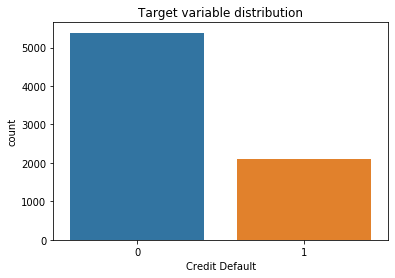

In [47]:
sns.countplot(x=TARGET_NAME, data=df)
plt.title('Target variable distribution');

**Оценка признака Annual Income в разреце целевой переменной**

In [48]:
from scipy.stats import shapiro
from scipy.stats import ttest_ind, mannwhitneyu

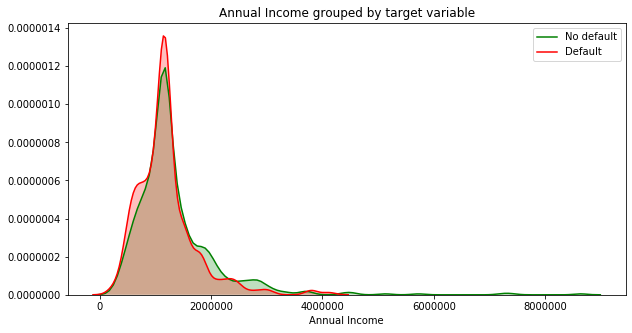

In [49]:
Annual_Income_with_target = df[['Annual Income', TARGET_NAME]].sample(1000)
Annual_Income = Annual_Income_with_target['Annual Income']
Annual_Income_target_0 = Annual_Income[Annual_Income_with_target[TARGET_NAME] == 0]
Annual_Income_target_1 = Annual_Income[Annual_Income_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Annual_Income_target_0, shade=True, label='No default', color='g')
sns.kdeplot(Annual_Income_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable');

**Наблюдение**

Группы, полученные в результате разбиения признака Annual Income по целевой переменной, имеют разные распределения. Это может означать, что между признаком и целевой переменной, есть зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\alpha=0.05$
* Критическая область: двухсторонняя

Чтобы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [50]:
stat, p = shapiro(Annual_Income)
p

6.493429197583106e-37

p-value меньше 0.05, значит гипотеза о "нормальности" отвергается

Оценим эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни

In [51]:
stat, p = mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)
p

0.0032215896014566865

p-value < 0,05 гипотиза о равности мат.ожиданий отвергается, значит Annual Income влияет на целевую переменную

Построим доверительные интервалы для средних значений каждой из двух групп и сравним их

In [52]:
import seaborn as sns
from matplotlib import pyplot as plt

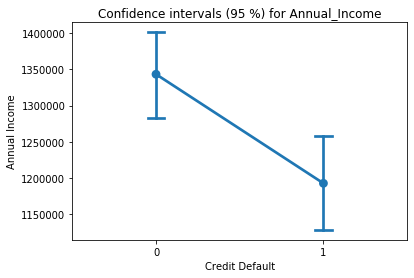

In [53]:
sns.pointplot(x=TARGET_NAME, y='Annual Income', data=Annual_Income_with_target, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual_Income');

**Оценка признака "Number of Open Accounts" в разреце целевой переменной**

Действуем по такому же алгоритму, как и для Annual Income

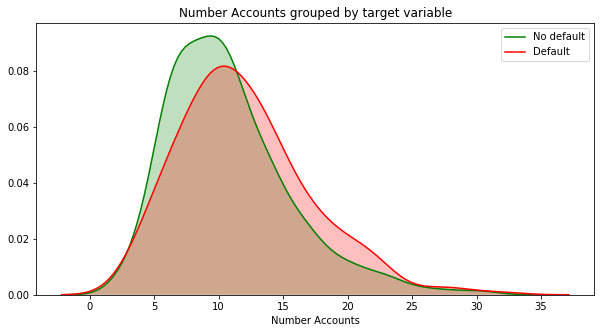

In [54]:
Number_Accounts_with_target = df[['Number of Open Accounts', TARGET_NAME]].sample(1000)
Number_Accounts = Number_Accounts_with_target['Number of Open Accounts']
Number_Accounts_target_0 = Number_Accounts[Number_Accounts_with_target[TARGET_NAME] == 0]
Number_Accounts_target_1 = Number_Accounts[Number_Accounts_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Number_Accounts_target_0, shade=True, label='No default', color='g')
sns.kdeplot(Number_Accounts_target_1, shade=True, label='Default', color='r')

plt.xlabel('Number Accounts')
plt.title('Number Accounts grouped by target variable');

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [55]:
stat, p = shapiro(Number_Accounts)
p

1.7488971123753267e-19

p-value меньше 0.05, значит гипотеза о "нормальности" отвергается

In [56]:
stat, p = mannwhitneyu(Number_Accounts_target_0, Number_Accounts_target_1)
p

6.76101318513376e-05

p-value > 0,05 гипотиза о равности мат.ожиданий подтверждается, значит 'Number of Open Accounts' не влияет на целевую переменную

Построим доверительные интервалы для средних значений каждой из двух групп и сравним их

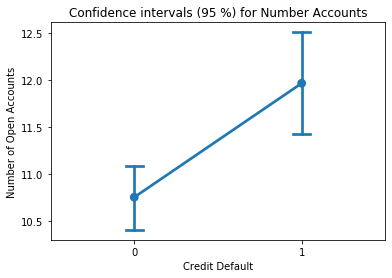

In [57]:
sns.pointplot(x=TARGET_NAME, y='Number of Open Accounts', data=Number_Accounts_with_target, capsize=.1)
plt.title('Confidence intervals (95 %) for Number Accounts');

Доверительные интервалы пересекаются, значит признак не влияет на целевую переменную

**Оценка признака "Maximum Open Credit" в разреце целевой переменной**

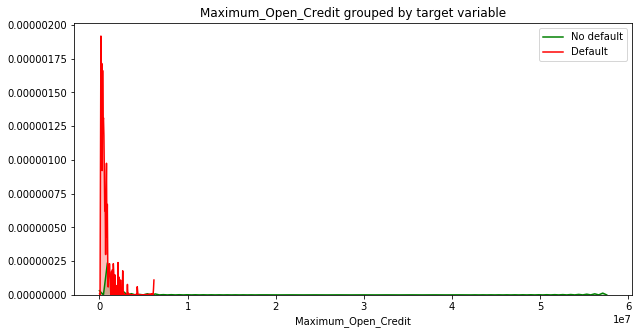

In [58]:
Maximum_Open_Credit_with_target = df[['Maximum Open Credit', TARGET_NAME]].sample(1000)
Maximum_Open_Credit = Maximum_Open_Credit_with_target['Maximum Open Credit']
Maximum_Open_Credit_target_0 = Maximum_Open_Credit[Maximum_Open_Credit_with_target[TARGET_NAME] == 0]
Maximum_Open_Credit_target_1 = Maximum_Open_Credit[Maximum_Open_Credit_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Maximum_Open_Credit_target_0, shade=True, label='No default', color='g', bw=1.5)
sns.kdeplot(Maximum_Open_Credit_target_1, shade=True, label='Default', color='r', bw=1.5)

plt.xlabel('Maximum_Open_Credit')
plt.title('Maximum_Open_Credit grouped by target variable');

In [59]:
stat, p = mannwhitneyu(Maximum_Open_Credit_target_0, Maximum_Open_Credit_target_1)
p

0.014636778100705322

p-value > 0,05 гипотиза о равности мат.ожиданий подтверждается, значит Maximum Open Credit не влияет на целевую переменную

Построим доверительные интервалы для средних значений каждой из двух групп и сравним их

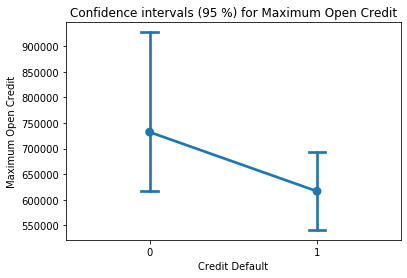

In [60]:
sns.pointplot(x=TARGET_NAME, y='Maximum Open Credit', data=Maximum_Open_Credit_with_target, capsize=.1)
plt.title('Confidence intervals (95 %) for Maximum Open Credit');

Доверительные интервалы пересекаются

**Оценка признака "Months since last delinquent" в разреце целевой переменной**

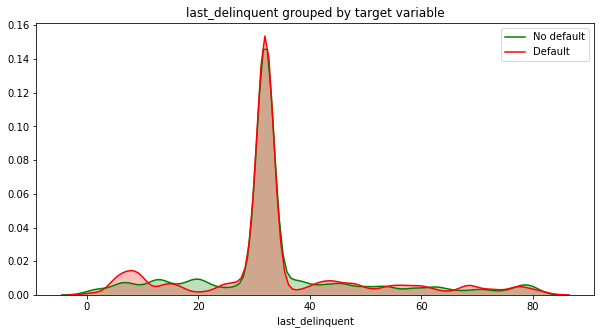

In [61]:
last_delinquent_with_target = df[['Months since last delinquent', TARGET_NAME]].sample(1000)
last_delinquent = last_delinquent_with_target['Months since last delinquent']
last_delinquent_target_0 = last_delinquent[last_delinquent_with_target[TARGET_NAME] == 0]
last_delinquent_target_1 = last_delinquent[last_delinquent_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(last_delinquent_target_0, shade=True, label='No default', color='g', bw=1.5)
sns.kdeplot(last_delinquent_target_1, shade=True, label='Default', color='r', bw=1.5)

plt.xlabel('last_delinquent')
plt.title('last_delinquent grouped by target variable');

Распределение похоже на "нормальное", проверим

In [62]:
stat, p = shapiro(last_delinquent)
p

9.202864163477482e-32

p-value меньше 0.05, значит гипотеза о "нормальности" отвергается

In [63]:
stat, p = mannwhitneyu(last_delinquent_target_0, last_delinquent_target_1)
p

0.46369233930424114

p-value > 0,05 гипотиза о равности мат.ожиданий подтверждается, значит 'Number of Open Accounts' не влияет на целевую переменную

Построим доверительные интервалы для средних значений каждой из двух групп и сравним их

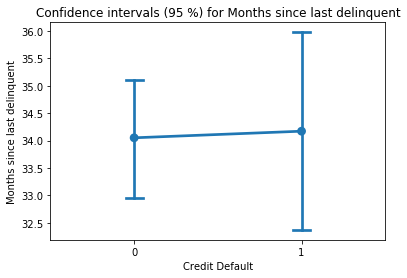

In [64]:
sns.pointplot(x=TARGET_NAME, y='Months since last delinquent', data=last_delinquent_with_target, capsize=.1)
plt.title('Confidence intervals (95 %) for Months since last delinquent');

Доверительные интервалы пересекаются, значит признак не влияет на целевую переменную

**Оценка признака "Bankruptcies" в разреце целевой переменной**

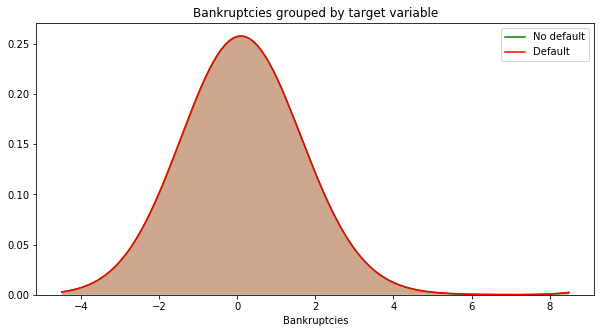

In [65]:
Bankruptcies_with_target = df[['Bankruptcies', TARGET_NAME]].sample(1000)
Bankruptcies = Bankruptcies_with_target['Bankruptcies']
Bankruptcies_target_0 = Bankruptcies[Bankruptcies_with_target[TARGET_NAME] == 0]
Bankruptcies_target_1 = Bankruptcies[Bankruptcies_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Bankruptcies_target_0, shade=True, label='No default', color='g', bw=1.5)
sns.kdeplot(Bankruptcies_target_1, shade=True, label='Default', color='r', bw=1.5)

plt.xlabel('Bankruptcies')
plt.title('Bankruptcies grouped by target variable');

In [66]:
stat, p = shapiro(Bankruptcies)
p

0.0

In [67]:
stat, p = mannwhitneyu(Bankruptcies_target_0, Bankruptcies_target_1)
p

0.31372434452433523

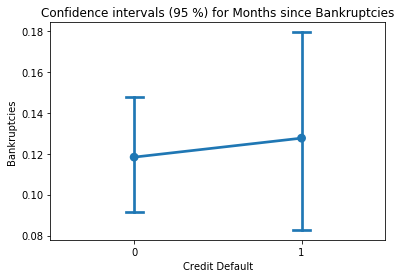

In [68]:
sns.pointplot(x=TARGET_NAME, y='Bankruptcies', data=Bankruptcies_with_target, capsize=.1)
plt.title('Confidence intervals (95 %) for Months since Bankruptcies');

Доверительные интервалы пересекаются, значит признак не влияет на целевую переменную

**Оценка признака "Current Loan Amount" в разреце целевой переменной**

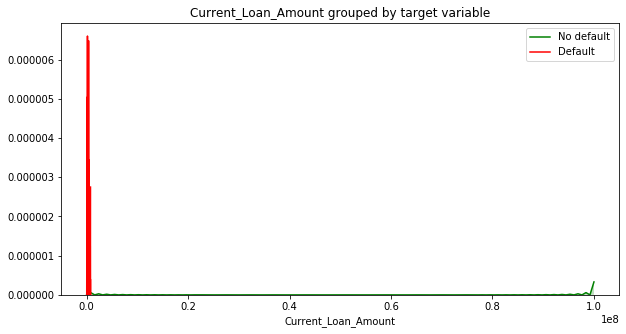

In [69]:
Current_Loan_Amount_with_target = df[['Current Loan Amount', TARGET_NAME]].sample(1000)
Current_Loan_Amount = Current_Loan_Amount_with_target['Current Loan Amount']
Current_Loan_Amount_target_0 = Current_Loan_Amount[Current_Loan_Amount_with_target[TARGET_NAME] == 0]
Current_Loan_Amount_target_1 = Current_Loan_Amount[Current_Loan_Amount_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Current_Loan_Amount_target_0, shade=True, label='No default', color='g', bw=1.5)
sns.kdeplot(Current_Loan_Amount_target_1, shade=True, label='Default', color='r', bw=1.5)

plt.xlabel('Current_Loan_Amount')
plt.title('Current_Loan_Amount grouped by target variable');

In [70]:
stat, p = mannwhitneyu(Current_Loan_Amount_target_0, Current_Loan_Amount_target_1)
p

0.05519266443059138

p-value > 0,05 гипотиза о равности мат.ожиданий отвергается, значит Current_Loan_Amount влияет на целевую переменную

Построим доверительные интервалы для средних значений каждой из двух групп и сравним их

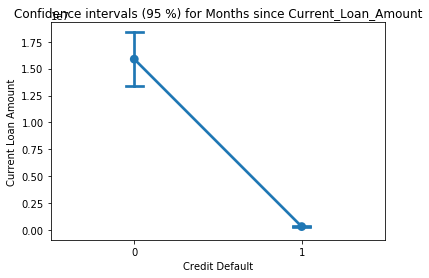

In [71]:
sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=Current_Loan_Amount_with_target, capsize=.1)
plt.title('Confidence intervals (95 %) for Months since Current_Loan_Amount');

Доверительные интервалы пересекаются, значит признак Current Loan Amount влияет на целевую переменную

**Оценка признака "Current Credit Balance" в разреце целевой переменной**

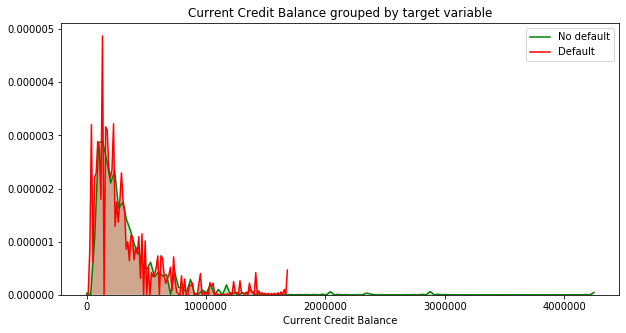

In [72]:
Current_Credit_Balance_with_target = df[['Current Credit Balance', TARGET_NAME]].sample(1000)
Current_Credit_Balance = Current_Credit_Balance_with_target['Current Credit Balance']
Current_Credit_Balance_target_0 = Current_Credit_Balance[Current_Credit_Balance_with_target[TARGET_NAME] == 0]
Current_Credit_Balance_target_1 = Current_Credit_Balance[Current_Credit_Balance_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Current_Credit_Balance_target_0, shade=True, label='No default', color='g', bw=1.5)
sns.kdeplot(Current_Credit_Balance_target_1, shade=True, label='Default', color='r', bw=1.5)

plt.xlabel('Current Credit Balance')
plt.title('Current Credit Balance grouped by target variable');

In [73]:
stat, p = shapiro(Current_Credit_Balance)
p

1.2689163971015873e-39

In [74]:
stat, p = mannwhitneyu(Current_Credit_Balance_target_0, Current_Credit_Balance_target_1)
p

0.16726857197933637

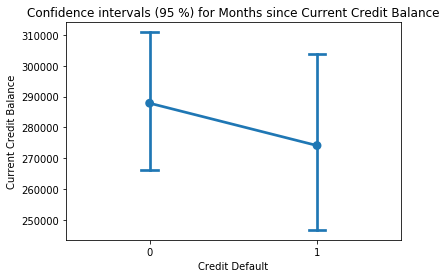

In [75]:
sns.pointplot(x=TARGET_NAME, y='Current Credit Balance', data=Current_Credit_Balance_with_target, capsize=.1)
plt.title('Confidence intervals (95 %) for Months since Current Credit Balance');

Доверительные интервалы пересекаются, значит признак не влияет на целевую переменную

**Оценка признака "Monthly Debt" в разреце целевой переменной**

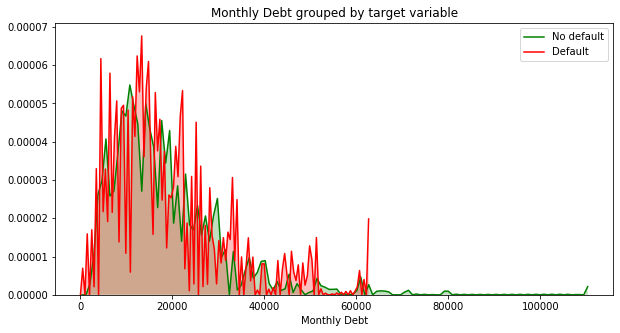

In [76]:
Monthly_Debt_with_target = df[['Monthly Debt', TARGET_NAME]].sample(1000)
Monthly_Debt = Monthly_Debt_with_target['Monthly Debt']
Monthly_Debt_target_0 = Monthly_Debt[Monthly_Debt_with_target[TARGET_NAME] == 0]
Monthly_Debt_target_1 = Monthly_Debt[Monthly_Debt_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Monthly_Debt_target_0, shade=True, label='No default', color='g', bw=1.5)
sns.kdeplot(Monthly_Debt_target_1, shade=True, label='Default', color='r', bw=1.5)

plt.xlabel('Monthly Debt')
plt.title('Monthly Debt grouped by target variable');

In [77]:
stat, p = mannwhitneyu(Monthly_Debt_target_0, Monthly_Debt_target_1)
p

0.21860874460905377

p-value > 0,05 гипотиза о равности мат.ожиданий подтверждается, значит Current_Loan_Amount не влияет на целевую переменную

Построим доверительные интервалы для средних значений каждой из двух групп и сравним их

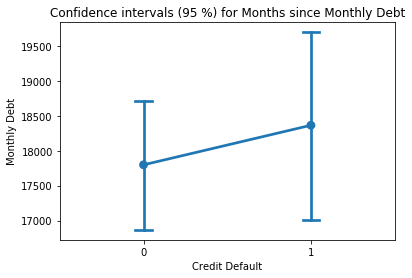

In [78]:
sns.pointplot(x=TARGET_NAME, y='Monthly Debt', data=Monthly_Debt_with_target, capsize=.1)
plt.title('Confidence intervals (95 %) for Months since Monthly Debt');

Доверительные интервалы пересекаются, значит признак не влияет на целевую переменную

**Оценка признака "Credit Score" в разреце целевой переменной**

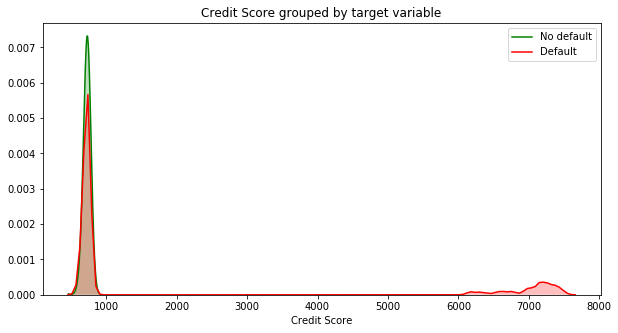

In [79]:
Credit_Score_with_target = df[['Credit Score', TARGET_NAME]].sample(1000)
Credit_Score = Credit_Score_with_target['Credit Score']
Credit_Score_target_0 = Credit_Score[Credit_Score_with_target[TARGET_NAME] == 0]
Credit_Score_target_1 = Credit_Score[Credit_Score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Credit_Score_target_0, shade=True, label='No default', color='g', bw=50)
sns.kdeplot(Credit_Score_target_1, shade=True, label='Default', color='r', bw=50)

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable');

In [80]:
stat, p = shapiro(Credit_Score)
p

0.0

In [81]:
stat, p = mannwhitneyu(Credit_Score_target_0, Credit_Score_target_1)
p

0.13761269076725274

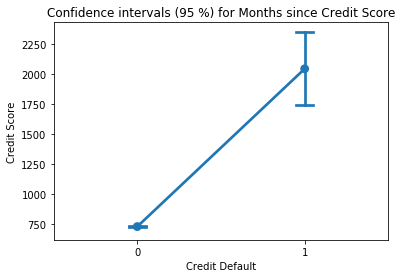

In [82]:
sns.pointplot(x=TARGET_NAME, y='Credit Score', data=Credit_Score_with_target, capsize=.1)
plt.title('Confidence intervals (95 %) for Months since Credit Score');

Доверительные интервалы не пересекаются, значит признак влияет на целевую переменную

### Анализ признакового пространства

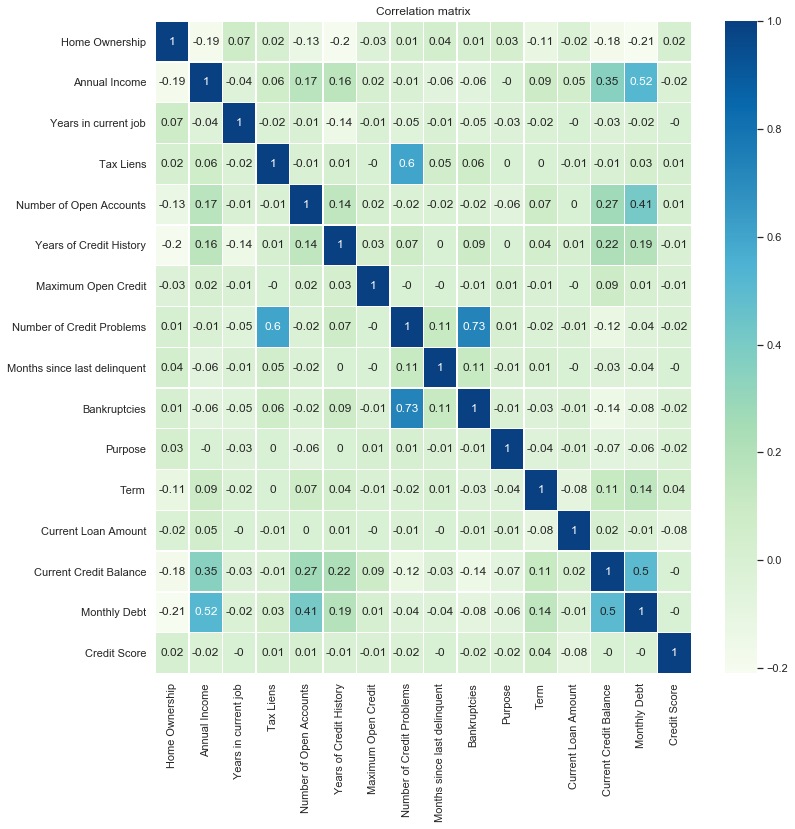

In [85]:
plt.figure(figsize = (12,12))

sns.set(font_scale=1)
sns.heatmap(df[NEW_FEATURE_NAMES].corr().round(2), annot=True, linewidths=.3, cmap='GnBu')
plt.title('Correlation matrix');

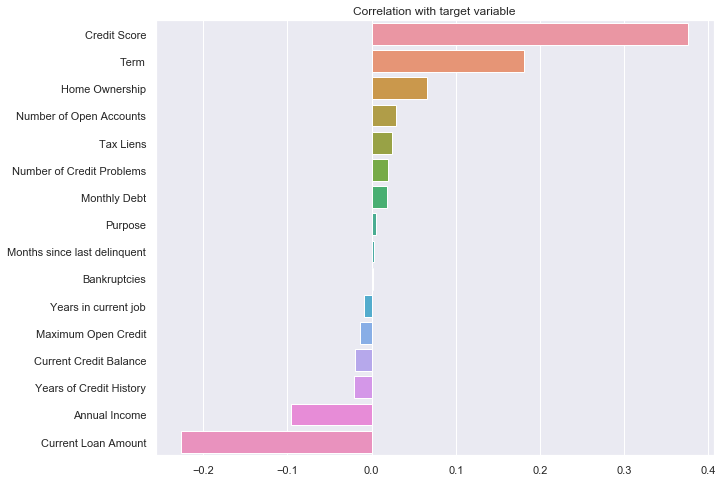

In [86]:
corr_with_target = df[NEW_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable');

Видим влияние прикзнков Credit Score, Term, Home Ownership, Annual Income, Current Loan Amount 

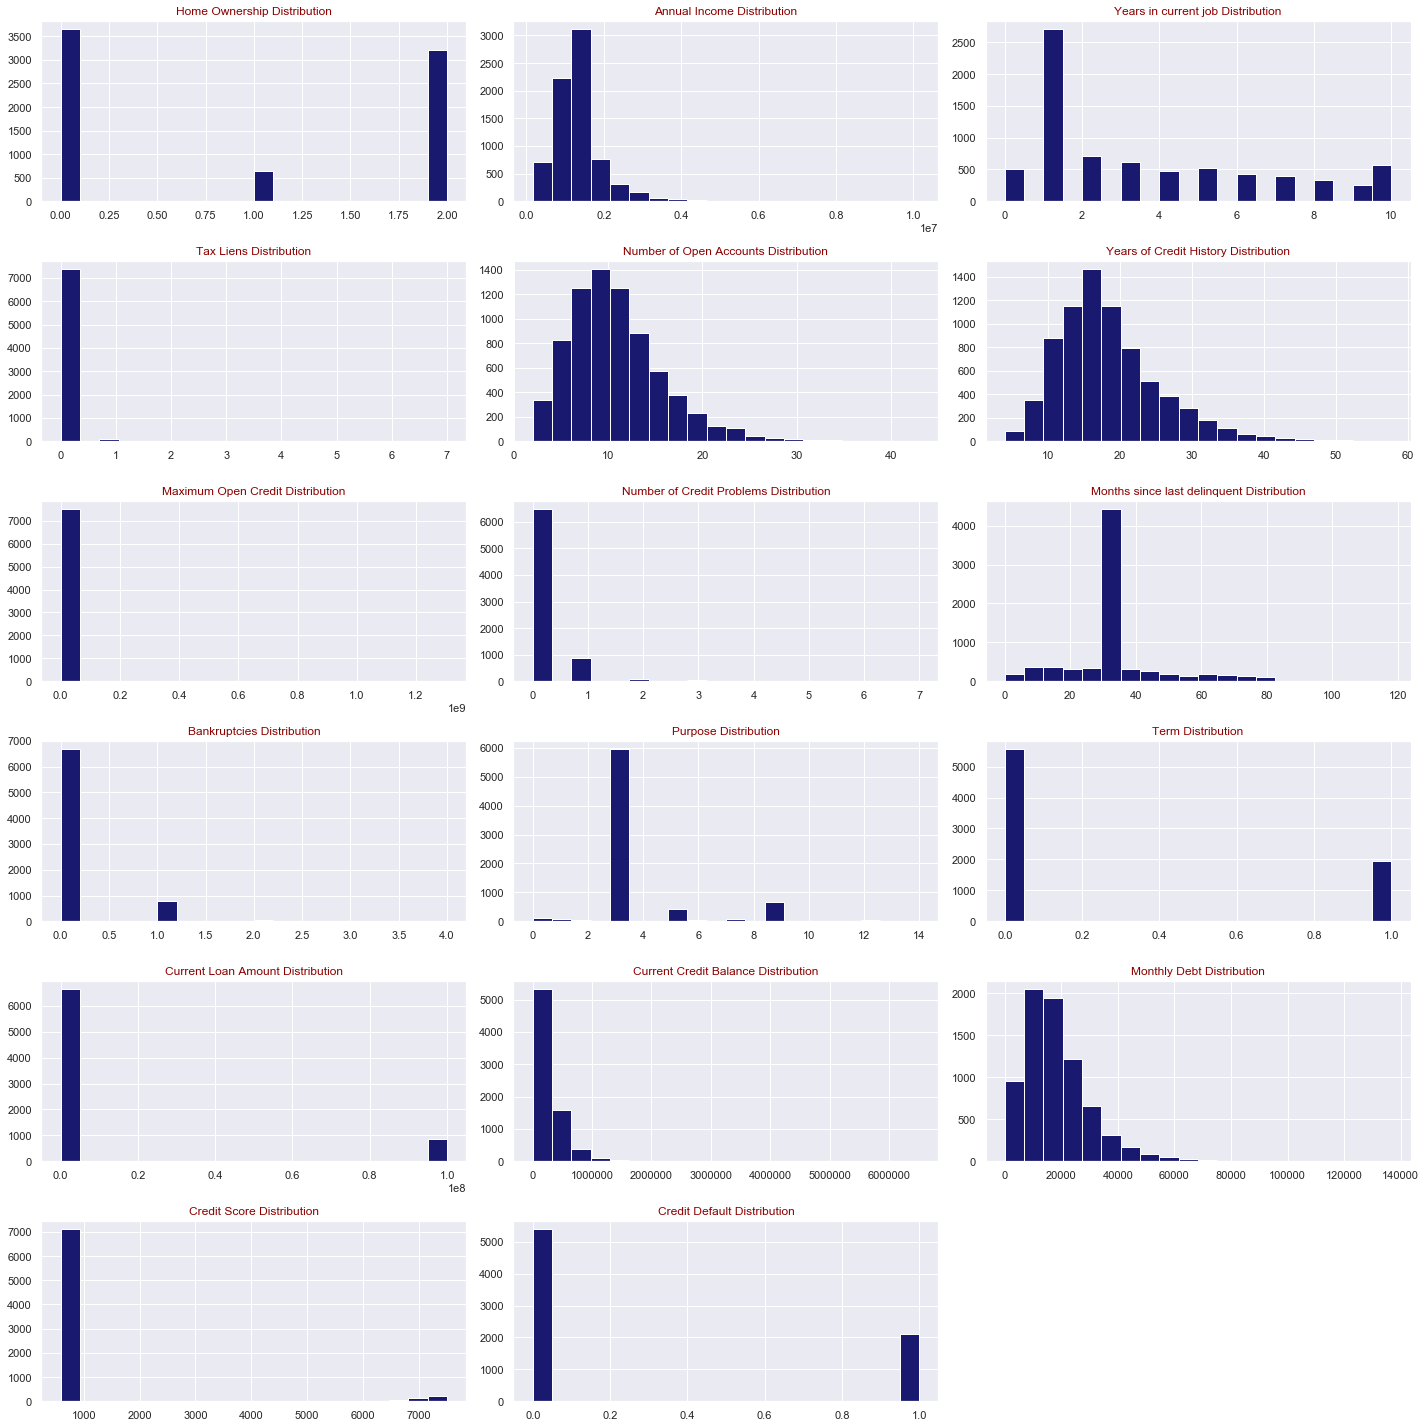

In [87]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.columns,6,3)

Отдельно выделим категориальные признаки

In [88]:
CAT_FEATURE_NAMES = [col for col in df.drop(TARGET_NAME, axis=1).columns \
                     if len(df[col].unique()) <= 12] 
print(CAT_FEATURE_NAMES)

['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Term']


Отдельно выделим непрерывные признаки

In [92]:
NUM_FEATURE_NAMES = [col for col in NEW_FEATURE_NAMES if col not in CAT_FEATURE_NAMES]
print(NUM_FEATURE_NAMES)

['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent', 'Purpose', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']


In [93]:
SELECTED_FEATURE_NAMES = CAT_FEATURE_NAMES + NUM_FEATURE_NAMES
print(len(SELECTED_FEATURE_NAMES))

16


Проиндексируем категориальные признаки

In [94]:
cat_features = [i for i, col in enumerate(SELECTED_FEATURE_NAMES) if col in CAT_FEATURE_NAMES]
cat_features

[0, 1, 2, 3, 4, 5]

### Разбиение на train и valid

In [95]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape 

((5250, 16), (2250, 16), (5250,), (2250,))

In [96]:
X_train[SELECTED_FEATURE_NAMES].iloc[:,cat_features].columns

Index(['Home Ownership', 'Years in current job', 'Tax Liens',
       'Number of Credit Problems', 'Bankruptcies', 'Term'],
      dtype='object')

### Балансировка целевой переменной

In [97]:
y_train.value_counts()

0    3771
1    1479
Name: Credit Default, dtype: int64

In [98]:
y_train.value_counts(normalize=True)

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

In [99]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [100]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

X_train.shape, y_train.shape

((6729, 16), (6729,))

### Сохранение обучающего и валидационного датасетов

In [101]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

In [102]:
TRAIN_FULL_PATH = 'course_project/training_project_train_full.csv'
TRAIN_PART_PATH = 'course_project/training_project_train_part.csv'
VALID_PART_PATH = 'course_project/training_project_valid_part.csv'

In [103]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
valid.to_csv(VALID_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей

**LightGBM**

In [104]:
scale = int(y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0])
scale

1

In [105]:
%%time

model_lgbm = lgbm.LGBMClassifier(random_state=21, max_depth=2, scale_pos_weight=scale, cat_feature=cat_features, silent=True)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.86      0.77      3771
           1       0.75      0.53      0.62      2958

    accuracy                           0.72      6729
   macro avg       0.72      0.69      0.70      6729
weighted avg       0.72      0.72      0.71      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1616
           1       0.56      0.50      0.53       634

    accuracy                           0.75      2250
   macro avg       0.69      0.67      0.68      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1371  245
1                318  316
Wall time: 157 ms


In [106]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

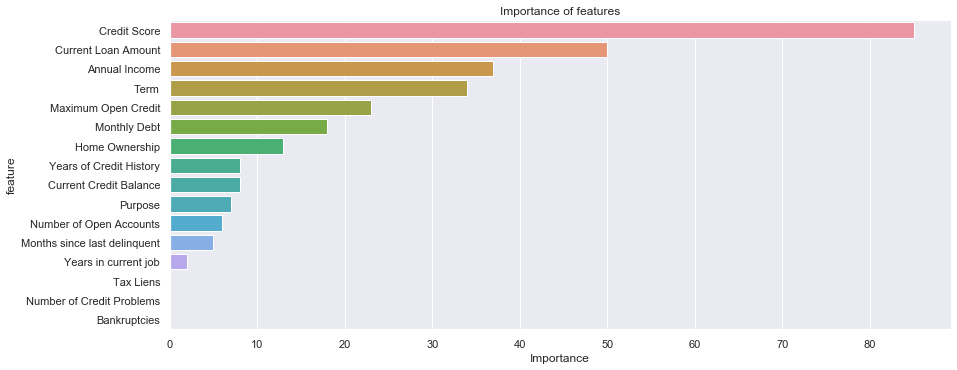

In [499]:
important_features_top = show_feature_importances(X_train.columns, 
                                                  model_lgbm.feature_importances_, 
                                                  get_top=16)

In [107]:
final_model = lgbm.LGBMClassifier(random_state=21, max_depth=2, scale_pos_weight=scale, cat_feature=cat_features, silent=True)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.86      0.77      3771
           1       0.75      0.53      0.62      2958

    accuracy                           0.72      6729
   macro avg       0.72      0.69      0.70      6729
weighted avg       0.72      0.72      0.71      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1616
           1       0.56      0.50      0.53       634

    accuracy                           0.75      2250
   macro avg       0.69      0.67      0.68      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1371  245
1                318  316


### Запуск модель по тестовой выборке и сохранение в файл

In [109]:
with open("course_project/model.pkl", 'wb') as file:
    pickle.dump(final_model, file)

In [110]:
y_test_pred_probs = final_model.predict_proba(df_test)[:, 1]

In [111]:
y_test_labels = np.where(
    y_test_pred_probs > 0.52, 1, 0
)
y_test_labels = np.array(y_test_pred_probs > 0.52, dtype=int)
pd.DataFrame(y_test_labels).to_csv('course_project/VEBelokobylskaya_predictions.csv', header=None, index=None)

In [112]:
y_test_pred_probs

array([0.73782926, 0.74277673, 0.99647011, ..., 0.62079485, 0.66861169,
       0.99546924])